In [3]:
import ginza
import numpy as np
import pandas as pd
import matplotlib as mpl
import nltk, warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
from wordcloud import WordCloud, STOPWORDS
from fuzzywuzzy import fuzz
import MeCab
import seaborn as sns

# from sklearn.linear_model.

%matplotlib inline
from ginza import STOP_WORDS
from janome.tokenizer import Tokenizer
TK = Tokenizer()

## Constant variable

In [4]:
data_path = 'Whiskey_sample_data.csv'

## Data Exploration

In [5]:
def load_data(data_path):
    return pd.read_csv(data_path)

# def pipeline_

In [6]:
df_initial = load_data(data_path)

In [7]:
df_initial

,RowID,Name,Comment,Note,Body,Smoky,Woody,Floral,Fruity,Winey
0,1,Aberfeldy,1898年にジョン・デュワーの息子たちによって設立されたアバフェルディ蒸溜所。現在も木製ウォ...,（テイスティングノート）\n香り：オレンジトフィーやナッツ\n味わい：芳醇なハチミツのような...,2,2,4,2,2,2
1,2,Aberlour,NaN,厳選したシェリー樽とバーボン樽の2種類の樽を使って熟成する“ダブルカスクマチュレーション”が...,3,1,5,2,3,2
2,3,AnCnoc,NaN,NaN,1,2,4,2,3,0
3,4,Ardbeg,NaN,NaN,4,4,3,0,1,0
4,5,Ardmore,NaN,NaN,2,2,5,1,1,1
...,...,...,...,...,...,...,...,...,...,...
81,82,Tobermory,NaN,NaN,1,1,3,2,2,0
82,83,Tomatin,NaN,NaN,2,2,3,1,0,1
83,84,Tomintoul,NaN,NaN,0,1,3,2,1,1
84,85,Tormore,NaN,NaN,2,1,3,0,0,1


In [8]:
tab_infor = pd.DataFrame(df_initial.dtypes).T.rename(index={0: 'column type'})
tab_infor = tab_infor.append(pd.DataFrame(df_initial.isnull().sum(axis=0)).T.rename(index={0: 'null index value'}))
tab_infor = tab_infor.append(pd.DataFrame(df_initial.isnull().sum(axis=0)/df_initial.shape[0] * 100).T.rename(index={0: 'null index %'}))

In [9]:
tab_infor

,RowID,Name,Comment,Note,Body,Smoky,Woody,Floral,Fruity,Winey
column type,int64,object,object,object,int64,int64,int64,int64,int64,int64
null index value,0,0,79,80,0,0,0,0,0,0
null index %,0,0,91.8605,93.0233,0,0,0,0,0,0


In [10]:
## Comment preprocessing_

In [11]:
comments = df_initial.Comment.values.tolist()

In [12]:
wakati = MeCab.Tagger("-Owakati")

In [13]:
def pipe_keywords_flatten(comment):
    if comment is None or isinstance(comment, float): return ''
    token = []
    for s in TK.tokenize(comment):
        token.append(s.base_form)
        
    return '|'.join(token)    

In [14]:
def convert_original_format_to_new_format(df, columns=['Comment', 'Note']):
    df_new = df.copy()
    
    for col in columns:
        df_new[col] = df[col].apply(pipe_keywords_flatten)
    
    return df_new

In [15]:
df_converted = convert_original_format_to_new_format(df_initial)
df_converted

,RowID,Name,Comment,Note,Body,Smoky,Woody,Floral,Fruity,Winey
0,1,Aberfeldy,1898|年|に|ジョン・デュワー|の|息子|たち|によって|設立|する|れる|た|アバフェ...,（|テイスティングノート|）|\n|香り|：|オレンジトフィー|や|ナッツ|\n|味わい|：...,2,2,4,2,2,2
1,2,Aberlour,,厳選|する|た|シェリー|樽|と|バー|ボン|樽|の|2|種類|の|樽|を|使う|て|熟成|...,3,1,5,2,3,2
2,3,AnCnoc,,,1,2,4,2,3,0
3,4,Ardbeg,,,4,4,3,0,1,0
4,5,Ardmore,,,2,2,5,1,1,1
...,...,...,...,...,...,...,...,...,...,...
81,82,Tobermory,,,1,1,3,2,2,0
82,83,Tomatin,,,2,2,3,1,0,1
83,84,Tomintoul,,,0,1,3,2,1,1
84,85,Tormore,,,2,1,3,0,0,1


In [16]:
## Count keywords for comments and note

In [17]:
comment_keywords = set()
note_keywords = set()

In [18]:
columns = ['Comment', 'Note']

for idx, col in enumerate(columns):
    data = df_converted[col]
    
    for s in data.str.split('|'):
        if s is None or len(s) == 0: continue
        if idx == 0:
            comment_keywords = comment_keywords.union(s)
        else:
            note_keywords = note_keywords.union(s)

In [19]:
comment_keywords = [s for s in comment_keywords if len(s) != 0]

In [20]:
note_keywords = [s for s in note_keywords if len(s) != 0]

In [21]:
# Remove stopwords

In [22]:
comment_keywords_cleaned = [s for s in comment_keywords if s not in STOP_WORDS]
note_keywords_cleaned = [s for s in note_keywords if s not in STOP_WORDS]

In [23]:
len(comment_keywords_cleaned)

207

In [24]:
## Count keywords

In [25]:
key_counts = dict()
total_keywords = np.concatenate((comment_keywords_cleaned, note_keywords_cleaned))

for tk in total_keywords:
    for s in tk:
        key_counts[s] = key_counts[s] + 1 if s in key_counts else 1           

In [26]:
key_occurences = []
for (k, v) in key_counts.items():
    key_occurences.append([k, v])
    
key_occurences.sort(key = lambda x: x[1], reverse=True)

In [27]:
len(key_counts)

387

## Plot keywords

In [28]:
def random_color_func(word=None, position=None, font_size=None,
                      orientation=None, font_path=None, random_state=None):
    l = int(360.0 * tone / 255.0)
    h = int(100.0 * 255.0 / 255.0)
    s = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    
    return "hsl({}, {}%, {}%)".format(h, s, l)

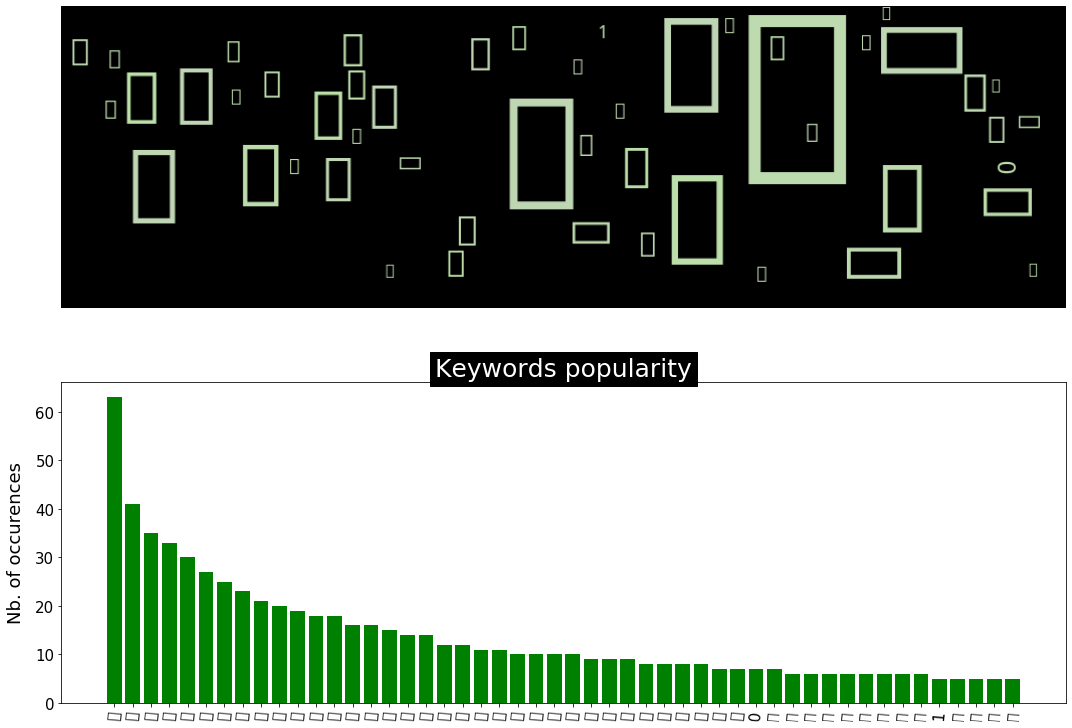

In [29]:
fig = plt.figure(1, figsize=(18, 13))
ax1 = fig.add_subplot(2,1,1)

words = dict()
trunc_occurences = key_occurences[:50]
for s in trunc_occurences:
    words[s[0]] = s[1]

tone = 55.0
wordcloud = WordCloud(width=1000, height=300, background_color='black',
                      max_words=10000, relative_scaling=1, color_func=random_color_func,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
ax1.imshow(wordcloud, interpolation='bilinear')
ax1.axis('off')

ax2 = fig.add_subplot(2,1,2)
y_axis = [i[1] for i in trunc_occurences]
x_axis = [k for k,i in enumerate(trunc_occurences)]
x_label = [i[0] for i in trunc_occurences]
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.xticks(x_axis, x_label)
plt.ylabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax2.bar(x_axis, y_axis, align = 'center', color='g')
#_______________________
plt.title("Keywords popularity", bbox={'facecolor':'k', 'pad':5}, color='w', fontsize = 25)
plt.show()

## Data Cleaning

In [30]:
df_converted.head()

,RowID,Name,Comment,Note,Body,Smoky,Woody,Floral,Fruity,Winey
0,1,Aberfeldy,1898|年|に|ジョン・デュワー|の|息子|たち|によって|設立|する|れる|た|アバフェ...,（|テイスティングノート|）|\n|香り|：|オレンジトフィー|や|ナッツ|\n|味わい|：...,2,2,4,2,2,2
1,2,Aberlour,,厳選|する|た|シェリー|樽|と|バー|ボン|樽|の|2|種類|の|樽|を|使う|て|熟成|...,3,1,5,2,3,2
2,3,AnCnoc,,,1,2,4,2,3,0
3,4,Ardbeg,,,4,4,3,0,1,0
4,5,Ardmore,,,2,2,5,1,1,1


In [31]:
def convert_int_to_string(number):
    number_string_list = ['zeros', 'one', 'two', 'three', 'four', 'five', 'six']
    
    return number_string_list[number]

In [32]:
columns = ['Body', 'Smoky', 'Woody', 'Floral', 'Fruity', 'Winey']
df_converted_new = df_converted.copy(deep=True)

for col in columns:
    df_converted_new[col] = df_converted[col].apply(convert_int_to_string)

In [33]:
flavour_keywords = []

df_flavour = pd.DataFrame(df_converted_new[columns])

In [34]:
for index, row in df_flavour.iterrows():
    flavour_keywords.append(' '.join(list(row)))

In [35]:
flavour_matrix = df_converted.as_matrix()[:, -6:]

In [36]:
flavour_matrix.shape

(86, 6)

In [37]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/datnguyen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
tfidf = TfidfVectorizer()

In [39]:
X = tfidf.fit_transform(flavour_keywords)

In [40]:
from sklearn.metrics.pairwise import cosine_similarity

In [41]:
cosine_similarity = cosine_similarity(X, X)

In [42]:
cosine_similarity

array([[1.        , 0.37300765, 0.69673648, ..., 0.23088114, 0.21832484,
        0.51123128],
       [0.37300765, 1.        , 0.49032752, ..., 0.46357802, 0.38223423,
        0.55678519],
       [0.69673648, 0.49032752, 1.        , ..., 0.68558424, 0.74074358,
        0.81862125],
       ...,
       [0.23088114, 0.46357802, 0.68558424, ..., 1.        , 0.89026279,
        0.93068877],
       [0.21832484, 0.38223423, 0.74074358, ..., 0.89026279, 1.        ,
        0.89572417],
       [0.51123128, 0.55678519, 0.81862125, ..., 0.93068877, 0.89572417,
        1.        ]])

In [43]:
def get_top_liquor(liquor_id):
    index = df_converted[df_converted['RowID'] == liquor_id].index[0]
    list_similarities = pd.Series(cosine_similarity[index])
    similarities_indices = list_similarities.sort_values(ascending=False)
    print(similarities_indices)
    top_10_similarities = similarities_indices.iloc[:5].index
    print(top_10_similarities)
    list_liquor = []
    
    for i in top_10_similarities:
        list_liquor.append(df_converted.iloc[i][columns].tolist())
        
    return list_liquor

In [44]:
from random import randint

liquor_id = randint(1, df_converted.shape[0])

In [45]:
results = get_top_liquor(liquor_id)

71    1.000000
52    1.000000
7     1.000000
19    1.000000
73    1.000000
        ...   
1     0.401629
61    0.349794
77    0.333076
23    0.304928
6     0.147450
Length: 86, dtype: float64
Int64Index([71, 52, 7, 19, 73], dtype='int64')


In [46]:
results

[[2, 1, 4, 2, 2, 1],
 [2, 1, 4, 2, 1, 2],
 [2, 1, 4, 1, 2, 2],
 [1, 2, 4, 2, 2, 1],
 [2, 1, 4, 2, 2, 1]]

In [47]:
np.array(df_converted.iloc[liquor_id][columns].tolist())

array([1, 1, 3, 3, 2, 1])

## Evaluation results

In [103]:
import math

def evaluation(input_vector, results):
    mse = 0
        
    for i in range(len(results)):
        redudant = np.array(results[i]) - np.array(input_vector)
        mse += (redudant*redudant).sum()
    
    print(mse)
    return math.sqrt(mse) / len(results)

In [104]:
print(evaluation(df_converted.iloc[liquor_id][columns].tolist(), results))

60
1.5491933384829668
